In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [2]:
prototxtPath=os.path.sep.join([r'D:\tryout','deploy.prototxt'])
weightsPath=os.path.sep.join([r'D:\tryout','res10_300x300_ssd_iter_140000.caffemodel'])


In [3]:
prototxtPath


'D:\\tryout\\deploy.prototxt'

In [4]:
weightsPath


'D:\\tryout\\res10_300x300_ssd_iter_140000.caffemodel'

In [5]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [6]:
net

<dnn_Net 0000020088DF5E50>

In [7]:
model=load_model(r'D:/tryout/mobilenet_v2.model')

In [8]:
image=cv2.imread(r'D:\tryout\00002.png')

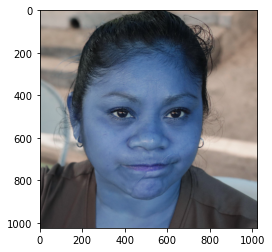

In [9]:
plt.imshow(image)

In [10]:
image

array([[[194, 177, 164],
        [194, 177, 164],
        [194, 177, 164],
        ...,
        [147, 124, 109],
        [145, 122, 106],
        [145, 122, 106]],

       [[194, 177, 164],
        [194, 177, 164],
        [194, 177, 164],
        ...,
        [147, 124, 109],
        [145, 122, 106],
        [145, 122, 106]],

       [[193, 177, 164],
        [193, 177, 164],
        [193, 177, 164],
        ...,
        [145, 122, 107],
        [143, 120, 105],
        [143, 120, 104]],

       ...,

       [[ 46,  44,  44],
        [ 44,  42,  42],
        [ 44,  42,  42],
        ...,
        [ 64,  59,  60],
        [ 59,  57,  57],
        [ 57,  56,  55]],

       [[ 46,  44,  44],
        [ 45,  43,  43],
        [ 45,  43,  43],
        ...,
        [ 62,  56,  57],
        [ 57,  54,  54],
        [ 58,  56,  56]],

       [[ 46,  44,  44],
        [ 45,  43,  43],
        [ 45,  43,  43],
        ...,
        [ 59,  54,  55],
        [ 57,  55,  55],
        [ 57,  55,  55]]

In [11]:
(h,w)=image.shape[:2]

In [12]:
(h,w)

(1024, 1024)

In [13]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [14]:
blob

array([[[[  90.,   88.,   90., ...,   42.,   41.,   41.],
         [  88.,   88.,   88., ...,   38.,   40.,   40.],
         [  87.,   86.,   86., ...,   38.,   38.,   39.],
         ...,
         [ -59.,  -61.,  -61., ...,  -31.,  -33.,  -36.],
         [ -60.,  -60.,  -61., ...,  -34.,  -35.,  -40.],
         [ -59.,  -61.,  -59., ...,  -33.,  -37.,  -46.]],

        [[   0.,    0.,    1., ...,  -54.,  -55.,  -55.],
         [   2.,    2.,    2., ...,  -58.,  -56.,  -56.],
         [   2.,    1.,    1., ...,  -58.,  -58.,  -57.],
         ...,
         [-134., -136., -136., ..., -109., -112., -114.],
         [-135., -135., -136., ..., -112., -113., -115.],
         [-134., -136., -134., ..., -111., -115., -122.]],

        [[  41.,   41.,   42., ...,  -15.,  -16.,  -17.],
         [  42.,   42.,   42., ...,  -19.,  -17.,  -18.],
         [  46.,   45.,   45., ...,  -19.,  -19.,  -18.],
         ...,
         [ -80.,  -82.,  -82., ...,  -54.,  -57.,  -59.],
         [ -81.,  -81.,  -

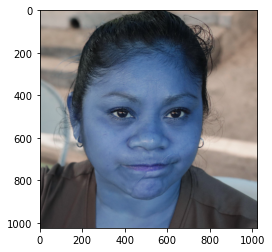

In [15]:
plt.imshow(image)

In [16]:
blob.shape

(1, 3, 300, 300)

In [17]:
net.setInput(blob)
detections=net.forward()

In [18]:
detections

array([[[[0.        , 1.        , 0.99988985, ..., 0.1882301 ,
          0.7405195 , 0.8610005 ],
         [0.        , 1.        , 0.9988263 , ..., 0.5229258 ,
          1.0692992 , 1.1940849 ],
         [0.        , 1.        , 0.12693065, ..., 2.1652484 ,
          2.7487583 , 2.8532686 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [19]:
#loop over the detections
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    
    
    if confidence>0.5:
        #we need the X,Y coordinates
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0)
        
        (mask,withoutMask)=model.predict(face)[0]
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
        
        
cv2.imshow("OutPut",image)
cv2.waitKey(0)
cv2.destroyAllWindows()